<a href="https://colab.research.google.com/github/aatika-hakim/AI/blob/main/00_chat_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%%capture --no-stderr
%pip install -U langgraph langchain-core langchain-community google-cloud

In [13]:
%pip install -qU langchain-google-genai

In [27]:
from google.colab import userdata
import os

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-8b",
    temperature=0,
    GEMINI_API_KEY=GEMINI_API_KEY
)

In [16]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from typing_extensions import TypedDict
from IPython.display import Image, display

In [30]:
# Initialize the LLM (ChatGoogleGenerativeAI)
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-8b",
    temperature=0
)

# Memory setup
memory = ConversationBufferMemory(return_messages=True)


In [31]:
# Define the state structure
class State(TypedDict):
    query: str
    category: str
    response: str


In [32]:
def use_tool(state: State) -> State:
    """Use LangChain tools to handle specific tasks, but here it's just an LLM response."""
    query = state["query"]
    try:
        response = llm.query(query)  # Just use the LLM to get the response
        state["response"] = response
    except Exception as e:
        state["response"] = f"An error occurred: {str(e)}"
    return state

# Categorize queries
def categorize_query(state: State) -> State:
    """Categorize the weather query into relevant categories."""
    prompt = ChatPromptTemplate.from_template(
        """
        Categorize the following query into one of these categories:
        'Current Weather', 'Forecast', 'Weather Tips', 'General Advice', or 'Use Tools'.
        Query: {query}

        Conversation History:
        {history}
        """
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["category"] = category
    memory.save_context({"Human": state["query"]}, {"AI": category})
    return state

# Routing logic
def route_query(state: State) -> str:
    """Route the query based on its category."""
    category = state.get("category", "")
    if category == "Current Weather":
        return "handle_current_weather"
    elif category == "Forecast":
        return "handle_forecast"
    elif category == "Weather Tips":
        return "handle_weather_tips"
    elif category == "Use Tools":
        return "use_tool"
    else:
        return "handle_general_advice"

In [33]:
def use_tool(state: State) -> State:
    """Use LangChain tools to handle specific tasks, but here it's just an LLM response."""
    query = state["query"]
    try:
        response = llm.query(query)  # Just use the LLM to get the response
        state["response"] = response
    except Exception as e:
        state["response"] = f"An error occurred: {str(e)}"
    return state

# Categorize queries
def categorize_query(state: State) -> State:
    """Categorize the weather query into relevant categories."""
    prompt = ChatPromptTemplate.from_template(
        """
        Categorize the following query into one of these categories:
        'Current Weather', 'Forecast', 'Weather Tips', 'General Advice', or 'Use Tools'.
        Query: {query}

        Conversation History:
        {history}
        """
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["category"] = category
    memory.save_context({"Human": state["query"]}, {"AI": category})
    return state

# Routing logic
def route_query(state: State) -> str:
    """Route the query based on its category."""
    category = state.get("category", "")
    if category == "Current Weather":
        return "handle_current_weather"
    elif category == "Forecast":
        return "handle_forecast"
    elif category == "Weather Tips":
        return "handle_weather_tips"
    elif category == "Use Tools":
        return "use_tool"
    else:
        return "handle_general_advice"


In [34]:
# Handle current weather
def handle_current_weather(state: State) -> State:
    """Provide the current weather information based on the user's query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide current weather information for the following location: {query}"
    )
    chain = prompt | llm
    current_weather = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["response"] = current_weather
    memory.save_context({"Human": state["query"]}, {"AI": current_weather})
    return state

# Handle forecast
def handle_forecast(state: State) -> State:
    """Provide weather forecast based on the user's query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a weather forecast for the following location for the next few days: {query}"
    )
    chain = prompt | llm
    forecast = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["response"] = forecast
    memory.save_context({"Human": state["query"]}, {"AI": forecast})
    return state

# Handle weather tips
def handle_weather_tips(state: State) -> State:
    """Provide weather-related tips or advice for the user's query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide weather-related tips or advice for the following query: {query}"
    )
    chain = prompt | llm
    tips = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["response"] = tips
    memory.save_context({"Human": state["query"]}, {"AI": tips})
    return state

# Handle general advice
def handle_general_advice(state: State) -> State:
    """Provide general advice for the user's query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide general advice or suggestions for this query: {query}\n\nConversation History:\n{history}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"], "history": memory.buffer}).content
    state["response"] = response
    memory.save_context({"Human": state["query"]}, {"AI": response})
    return state


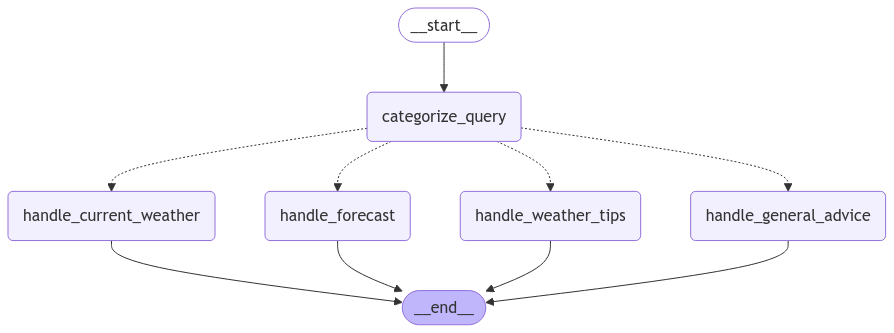

In [35]:
# Workflow setup
workflow = StateGraph(State)
workflow.add_edge(START, "categorize_query")
workflow.add_node("categorize_query", categorize_query)
workflow.add_node("handle_current_weather", handle_current_weather)
workflow.add_node("handle_forecast", handle_forecast)
workflow.add_node("handle_weather_tips", handle_weather_tips)
workflow.add_node("handle_general_advice", handle_general_advice)
workflow.add_conditional_edges(
    "categorize_query", route_query,
    ["handle_current_weather", "handle_forecast", "handle_weather_tips", "handle_general_advice"], END
)

# Compile the graph
graph = workflow.compile()

# Display the graph using Mermaid format (this is for visual debugging)
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")


In [ ]:
# Run the agent with user input
def run_agent(query: str):
    state = {"query": query, "category": "", "response": ""}
    state = categorize_query(state)  # Categorize the query
    route = route_query(state)  # Route the query to the correct handler

    # Call the appropriate handler
    if route == "handle_current_weather":
        state = handle_current_weather(state)
    elif route == "handle_forecast":
        state = handle_forecast(state)
    elif route == "handle_weather_tips":
        state = handle_weather_tips(state)
    else:
        state = handle_general_advice(state)

    # Output the response
    print(state["response"])

# Example of running the agent
query = "What's the weather like in New York today?"
run_agent(query)


ERROR:grpc._plugin_wrapping:AuthMetadataPluginCallback "<google.auth.transport.grpc.AuthMetadataPlugin object at 0x7a0b60427df0>" raised exception!
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 128, in refresh
    self._retrieve_info(request)
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/credentials.py", line 101, in _retrieve_info
    info = _metadata.get_service_account_info(
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 323, in get_service_account_info
    return get(request, path, params={"recursive": "true"})
  File "/usr/local/lib/python3.10/dist-packages/google/auth/compute_engine/_metadata.py", line 248, in get
    raise exceptions.TransportError(
google.auth.exceptions.TransportError: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Go